In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version: ', tf.__version__)
print('TFP version: ', tfp.__version__)

TF version:  2.4.1
TFP version:  0.12.1


# The DenseVariational layer

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create linear data with Gaussian noise

The data we will be working with is the same as we used before:

$$y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim \mathcal{N}(0,1)$ are independent and identically distributed. We will be running a Bayesian linear regression on this data.

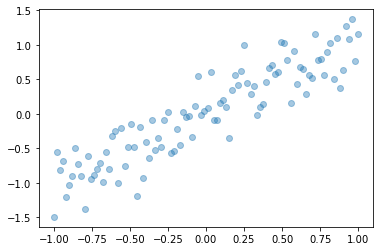

In [5]:
# Use the same data as before -- create and plot 100 data points

x_train = np.linspace(-1,1,100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.show()

We are now focused on modeling the epistemic uncertainty on our linear regression task. This means that we want to find a range of possible straight lines that generated this data. More than 1 straight line could have generated this data. The function $y=x$ actually generated the data, so it is one of the candidates but, for instance, $y = x+0.01$ could also possibly generated the data. This happens because we only have a sample of the whole data and a sample is imperfect.

This uncertainty is represented on the regression weights. Considering the we are doing linear regression, we only have two weights: the slope and the y-intercept. And so, we are looking for the uncertainty in those parameters, also called the epistemic uncertainty in this model weights.

#### Create the prior and posterior distribution for model weights

In [6]:
# Create the prior weight distribution -- all N(0,1) -- and not trainable

def prior(kernel_size, bias_size, dtype=None):
    # returns a distribution for weights in that layer
    n = kernel_size + bias_size
    # Notice that the sequential model does not have any parameters and it does not uses
    # the input, so if different x values are passed forward it returns the same distribution
    prior_model = Sequential([
        tfpl.DistributionLambda(
        lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    return prior_model

In [7]:
# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    # Here we are using a multivariate gaussian with full covariance.
    # We are parameterizing it using the lower triangular cov matrix
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

The idea of the Variational Bayes method is that is many settings and NN is not possible to use the Bayes theorem to calculate the true posterior. So, instead, we define a variational posterior, which is an approximation of the true posterior, and we tune the parameters of that variational posterior to be as close as possible to the true posterior. That is what we doing by using the `VariableLayer`.

#### Aside: analytical posterior

In this tutorial, we are using a variational posterior because, in most settings, it is not possible to derive an analytical one. However, in this simple setting, it is possible. Specifically, running a Bayesian linerar regression on $x_i$ and $y_i$ with $i=1, ..., n$ and a unit Gaussian prior on both $\alpha$ and $\beta$:

$$y_i = \alpha + \beta x_i + \epsilon_i, \quad \epsilon \sim \mathcal{N}(0,\sigma^2), \quad \alpha \sim \mathcal{N}(0,1), \quad \beta \sim \mathcal{N}(0,1)$$

gives a multivariate Gaussian posterior on $\alpha$ and $\beta$:

$$\left(\alpha \atop \beta \right) \sim \mathcal{N}(\mu, \Sigma)$$

where

$$\mu = \Sigma \left( \hat{n}\overline{y} \atop \hat{n}\bar{xy} \right) \quad \Sigma = \frac{1}{(\hat{n}+1)(\overline{\hat{n}x^2}+1)-\hat{n}^2\bar{x}^2}\begin{pmatrix}\overline{\hat{n}x^2}+1 & -\hat{n}\bar{x} \\
-\hat{n}\bar{x} & \hat{n}+1
\end{pmatrix}$$

In the above, $\hat{n}=\frac{n}{\sigma^2}$ and $\bar x = \frac{1}{n}\sum^n_{i=1}x_i$ for any $x$. In general, however, it is not possible to determine the analytical form of the posterior. For example, in models with a hidden layer with nonlinear activation function, the analytical posterior cannot be determined in general, and variational methods as below are useful.

#### Create the model with DenseVariational layers

In [10]:
# Create linear regression model with weight uncertainty: weights are
# distributed according to posterior (and, indirectly, prior) distribution

model = Sequential([
    tfpl.DenseVariational(input_shape=(1,),
                         units=1,
                         make_prior_fn=prior,
                         make_posterior_fn=posterior,
                         kl_weight=1/x_train.shape[0],
                         kl_use_exact=True)
])
model.compile(loss=MeanSquaredError(),
             optimizer=RMSprop(learning_rate=0.005))
model.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


Notice that we have 5 parameters. Deterministic linear regression only have 2 parameters: slope and y-intercept. Recall that the whole point of the DenseVariational layer is to replace each weight by a distribution and learn the parameters of that distribution. This is the number of paramters of the distributions that describe this model. We have the mean for the y-intercept, the mean for the slope, the variance for the y-tercept, the variance for the slope and the covariance between them.

#### Train model and inspect

In [11]:
# Fit the model, just like a deterministic linear regression

model.fit(x_train, y_train, epochs=500, verbose=False)

In [12]:
# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:            ', model_prior.mean().numpy())
print('prior variance:        ', model_prior.variance().numpy())
print('posterior mean:        ', model_posterior.mean().numpy())
print('posterior covariance:  ', model_posterior.covariance().numpy()[0])
print('                       ', model_posterior.covariance().numpy()[1])

prior mean:             [0. 0.]
prior variance:         [1. 1.]
posterior mean:         [1.0243577  0.02130365]
posterior covariance:   [0.0164075  0.00020567]
                        [0.00020567 0.00578971]


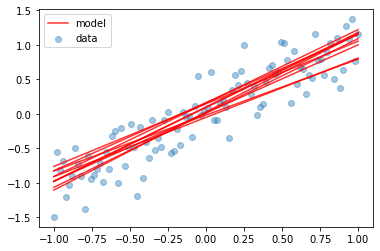

In [13]:
# Plot an ensemble of linear regressions, with weights sampled 
# from the posterior distribution

plt.scatter(x_train, y_train, alpha=0.4, label='data')
for _ in range(10):
    y_model = model(x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8, label='model')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)
        

plt.legend()
plt.show()

This plot shows an ensemble of, in this case, 10 possible lines that according to our posterior distribution could have generated this data. This represents our epistemic uncertainty. Recall that epistemic uncertainty decreases as we add more data.

#### Explore the effect of sample size

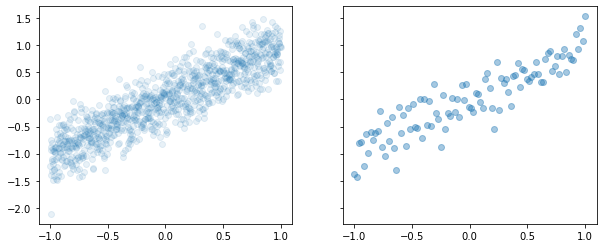

In [16]:
# Create two datasets, one with 1000 points, another with 100

x_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train_1000 = x_train_1000 + 0.3*np.random.randn(1000)[:, np.newaxis]

x_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train_100 = x_train_100 + 0.3*np.random.randn(100)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.scatter(x_train_1000, y_train_1000, alpha=0.1)
ax2.scatter(x_train_100, y_train_100, alpha=0.4)
plt.show()

We are creating two datasets from the same process but one has 1000 data points and the other has 100.

In [20]:
# Train a model on each dataset

model_1000 = Sequential([
    tfpl.DenseVariational(input_shape=(1,),
                         units=1,
                         make_prior_fn=prior,
                         make_posterior_fn=posterior,
                         kl_weight=1/1000)
])

model_100 = Sequential([
    tfpl.DenseVariational(input_shape=(1,),
                         units=1,
                         make_prior_fn=prior,
                         make_posterior_fn=posterior,
                         kl_weight=1/100)
])

model_1000.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))


model_1000.fit(x_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)

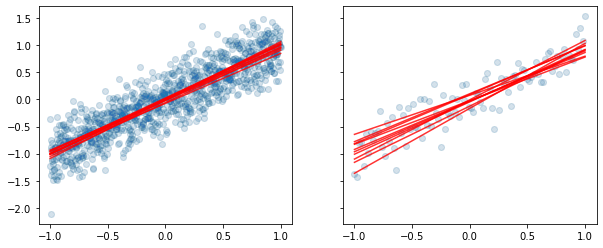

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for _ in range(10):
    y_model_1000 = model_1000(x_train_1000)
    ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02)
    ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8)
    y_model_100 = model_100(x_train_100)
    ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.02)
    ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8)
  
plt.show()

#### Put it all together: nonlinear probabilitistic regression with weight uncertainty

Let's change the data to being nonlinear:

$$y_i = x_i^3 + \frac{1}{10}(2+x_i)\epsilon_i$$
where $\epsilon_i \sim \mathcal{N}(0,1)$ are independent and identically distributed.

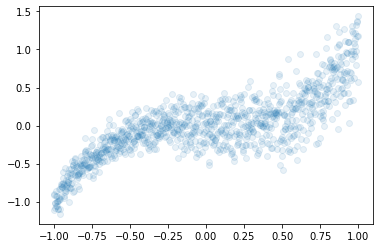

In [25]:
# Create and plot 1000 data points

x_train = np.linspace(-1,1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [26]:
# Create probabilistic regression with one hidden layer, weight uncertainty

model = Sequential([
    tfpl.DenseVariational(units=8,
                         input_shape=(1,),
                         make_prior_fn=prior,
                         make_posterior_fn=posterior,
                         kl_weight=1/x_train.shape[0],
                         activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                         make_prior_fn=prior,
                         make_posterior_fn=posterior,
                         kl_weight=1/x_train.shape[0]),
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_5 (DenseVa (None, 8)                 152       
_________________________________________________________________
dense_variational_6 (DenseVa (None, 2)                 189       
_________________________________________________________________
independent_normal (Independ multiple                  0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


With the last `IndependentNormal` layer we are modeling the aleatoric uncertainty, while with the `DenseVariational` layers we are modeling the epistemic uncertainty.

In [27]:
# Train the model

model.fit(x_train, y_train, epochs=1000, verbose=False)
model.evaluate(x_train, y_train)

32/32 [==============================] - 1s 613us/step - loss: -0.0513


-0.05131455883383751

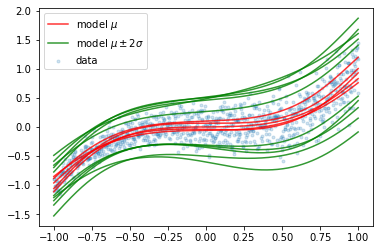

In [28]:
# Plot an ensemble of trained probabilistic regressions

plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='data')
for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
plt.legend()
plt.show()

We are modeling both the epistemic and aleatoric uncertainty. The uncertainty on the parameters (epistemic) is shown by the different values for the mean (red lines) and std (green lines).